### Case Study - Pinchout and Fault Scenarios
#### Showcasing LoopStructural-Flopy to address Model Structure Uncertainty

This notebook showcases how structural parameters, in this case CPz and fault_offset can be used to generate multiple structural models and address structural uncertainty in 3D groundwater models. This notebook contains the Pinchout and Fault Scenarios and use a synthetic example to explore uncertainty in pinchout location and fault geometry. 

In [12]:
import pandas as pd
import numpy as np
import subprocess
import sys
import os
import pickle
import functions # This is a project specific python script saved in folder functions.py
    
sys.path.append('../../MODFLOW_Tools') # This is how to import MODFLOW TOOLS modules    
%run ./figures.ipynb                   # Contains functions to produce figures

%load_ext autoreload
%autoreload 2
logfunc = lambda e: np.log10(e)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
sys.path.append('../../MODFLOW_Tools')
from loop2flopy import Project
P = Project('showcase', boundingbox = [0, 6000, 0, 6000, -500, 0]) # (x0, x1, y0, y1, z0, z1)

# Spatial information
P.crs = "epsg:28350" # Put in coordinate reference
P.xypumpbores = [] 
P.npump = len(P.xypumpbores)
P.idpumpbores = [] 
P.xyobsbores = [(1500,1000), (2500, 5000), (4000, 3000), (5000,1500)]
P.idobsbores = ['OB1', 'OB2', 'OB3', 'OB4'] 
#P.geo_coords=[(500,500), (1600, 2800), (5500,5500), (2800,1600)]
#P.geo_bores = ['P1', 'P2', 'P3', 'P4']

# Observation Points
P.nobs = len(P.xyobsbores)
obs_z = [-40, -50, -100, -200, -300]
P.nzobs = len(obs_z)
P.zobs = np.ones((P.nobs, P.nzobs))
for j in range(P.nzobs):
    P.zobs[:, j] = P.zobs[:, j] * obs_z[j] 

# Meshing parameters
P.triExeName = '../exe/triangle.exe'
P.fx1, P.fy1, P.fx2, P.fy2 = (2000, 4500, 3000, 1000) # fault end points
P.fault_buffer = 150.  # offset boundary from fault
P.r = 40               # refining factor for model boundary. High r has refined edges
P.w = 150              # interior boundary offset
P.boundmaxtri = 50000  # max triangle area in boundary area
P.modelmaxtri = 50000  # max triangle area in main model area
P.angle = 32           # minimum triangle angles
P.radius1 = 100        # radius of inner circle around pumping bores
P.radius2 = 200        # radius of outer circle around pumping bores
P.boremaxtri = 100000   # max triangle area within bore radius

# Flow model parameters
P.mfexe_name = '../exe/mf6.exe'
P.workspace = '../modelfiles/'
P.nlg = 4    # number of geological layers
P.nls = 2    # number sublayers for conformable
P.nlv  = 30  # number of layers for voxel transect grid
P.min_modlay_thick = [50, 50, 50, 50]
P.res = 2    # vertical resolution upon which voxel grid created to pick lithology bottoms

P.ss = [0.00009, 0.00007, 0.00002, 0.00008]
P.sy = [0.12, 0.1, 0.1, 0.1]

P.rch = 0.4/365 # 0.0027 m/d
P.strt = -20.
P.chfunc = lambda x,z: -(0.005*x) - (z * 0.02)-20 # horizontal gradient of 0.01 and vertical gradient of 0.02
P.xt3d = True
   
vtk_workspace = '../vtk_files'
if not os.path.isdir(vtk_workspace):
    os.makedirs(vtk_workspace, exist_ok=True)
    
if not os.path.isdir('../modelfiles'):
    os.makedirs(P.workspace, exist_ok=True)

In [14]:
from meshing_routines import createcell2d
P.obs_ref = 50
P.cell2dtri, P.xcyctri, P.verticestri, P.tri, trinodes = createcell2d(P, grid = 'tri', fault = True)  
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = True)  

[(150, 150), (5850, 150), (5850, 5850), (150, 5850)]


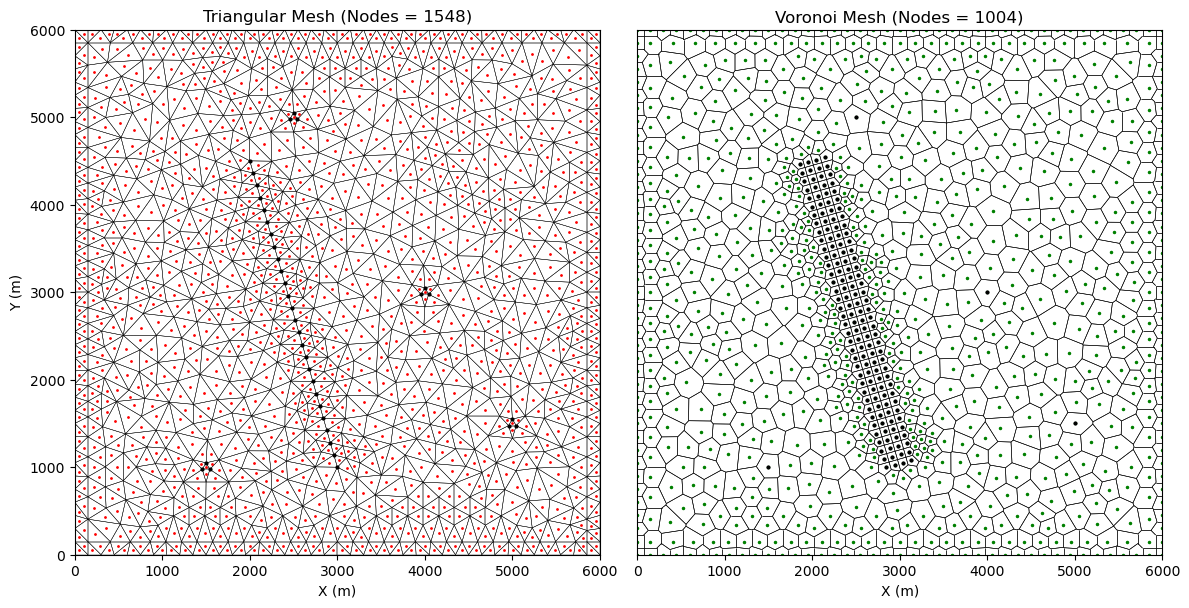

In [15]:
figure3(P)

### Faults - 6 simulations

In [ ]:
P.hk = [1, 2, 0.01, 5] 
P.vk = [i/10 for i in P.hk]

options = [0,50,120,150,200,250] # Fault displacement

data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "fault_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")

P.control_points = ([])
P.fault_max_disp = 100.    # Was 200
P.minor_axis = 1000        # Fault_influence - orthogonal to fault
P.fault_center = [P.fx1 + (P.fx2 - P.fx1)/2, P.fy1 + (P.fy2 - P.fy1)/2, -400]
P.fault_slip_vector=[0,0,1]
    
fault_modelnames, fault_models, fault_obs_heads = [],[],[]         

from loop2flopy import Model
for i in range(len(options)):
    fault_modelnames.append(str('FD_'+str(options[i])))  
    fault_models.append(Model(fault_modelnames[i], P, plan = 'vor', transect = 'con')) # Create flow model  
    P.fault_max_disp = options[i] 
    P.data, P.strat = functions.prepare_geomodel_loopshowcase(P, data, strat, include_fault = True)   # Prepare geomodel inputs
    P.geomodel = functions.create_geomodel_loopshowcase(P, include_fault = True) # Make geomodel
    M = fault_models[i]
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    results = M.write_run_model(P, period = 'Steady', ic_array = P.strt) 
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = results[0], results[1], results[2], results[-1]
    fault_obs_heads.append((functions.process_obs_steady(P, M)))
    f = os.path.join(vtk_workspace, "faults", M.modelname)
    M.gwf.export(f, fmt="vtk")

                          projected onto fault surface estimating from fault normal
C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Fault included!
   Creating lithology and discretisation arrays for  FD_0  ...
   Creating property arrays for  FD_0  ...
   Adding flow packages to  FD_0  ...
   Time taken =  0.572382
   Writing simulation and gwf for  FD_0  ...


In [ ]:
# PLOTS
#plot_bores(P)
#plot_observations(heads = fault_obs_heads, modelnames = fault_modelnames, ylim = [-40, -5])
#plot_bylayer(P, models = fault_models, layer = 2, vmin = -35, vmax = -10) 
#multiplot_vgrid_transect(P, models = fault_models, array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1)
#multiplot_prop_transect(P, models = fault_models, array = 'head_ss', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)

In [ ]:
figure6(P, models = fault_models, X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,vmin = -45, vmax = -5)

### Pinchout - 6 simulations

In [ ]:
P.hk = [1, 0.1, 10, 0.1] 
P.vk = [i/10 for i in P.hk]

#P.hk = [1.7, 0.07, 8.2, 0.5] 
#P.vk = [0.12,0.007,0.51,0.05] 

P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = False)    
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "pinchout_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")

options = np.linspace(-250, 0, 6) # control point z values

pinchout_modelnames, pinchout_models, pinchout_obs_heads = [],[],[]        
heads = []

for i in range(len(options)):
    pinchout_modelnames.append(str('PO_'+str(options[i])))  
    pinchout_models.append(Model(pinchout_modelnames[i], P, plan = 'vor', transect = 'con')) # Create flow model  
    P.control_points = (['CP1', 'control', 3000, 3000, options[i], -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
    
    P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
    P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel
    M = pinchout_models[i]
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = M.write_run_model(P, period = 'Steady', ic_array = P.strt)   
    pinchout_obs_heads.append((process_obs_steady(P, M)))
    heads.append((M.head_ss))
    f = os.path.join(vtk_workspace, "pinchouts", M.modelname)
    M.gwf.export(f, fmt="vtk")
    


In [14]:
#plot_bylayer(P, models = pinchout_models, layer = 1, vmin = -40, vmax = 20) 
#plot_observations(ylim = [-40, 20], modelnames = pinchout_modelnames, heads = pinchout_obs_heads)
#multiplot_vgrid_transect(P, models = pinchout_models, array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)
#multiplot_prop_transect(P, models = pinchout_models, array = 'head_ss', 
                        #X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1, vmin = -45, vmax = 10)

In [15]:
X0 = P.x0
Y0 = P.y0
X1 = P.x1
Y1 = P.y1
print(X0, Y0, X1, Y1)

0 0 6000 6000


C:\Users\19904604\AppData\Local\Temp\ipykernel_19928\1761316228.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\19904604\AppData\Local\Temp\ipykernel_19928\1761316228.py:133: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


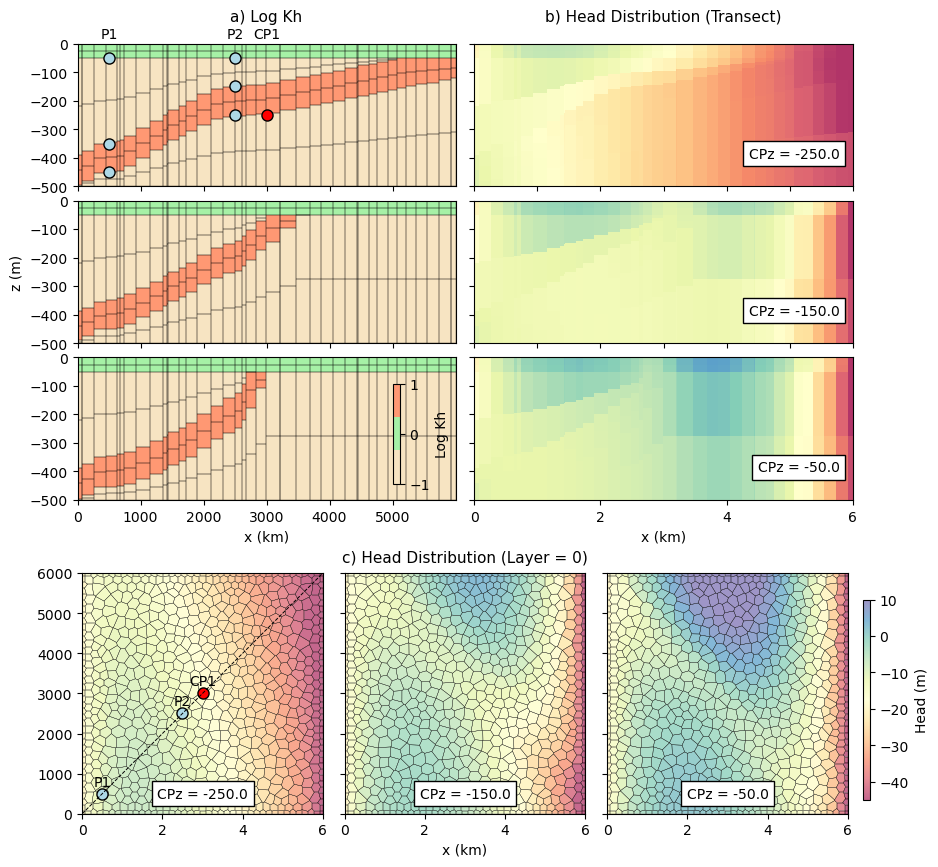

In [16]:
%run ./loop_showcase_functions.ipynb
figure5(P, models = pinchout_models, X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)

### Pinchout - 100 simulations

In [17]:
options = np.linspace(-250, 0, 100) # control point z values
    
heads_PO = []
for i in range(len(options)): 
    print(i)
    M = Model('PO', P, plan = 'vor', transect = 'con') # Create flow model  
    P.control_points = (['CP1', 'control', 3000, 3000, options[i], -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
    P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
    P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = M.write_run_model(P, period = 'Steady', ic_array = P.strt)   
    heads_PO.append((M.head_ss))


0
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.642355
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  8.147966
1
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.691816
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.895543
2
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.71302
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.256856
3
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.723138
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.731411
4
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.65245
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.391677
5
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.704147
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  8.762959
6
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.785306
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.765368
7
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.670985
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  8.740455
8
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.793641
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  8.072783
9
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.673442
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.636002
10
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.66609
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.401133
11
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.652704
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.311819
12
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.612811
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.250844
13
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.632521
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.347906
14
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.674379
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.426656
15
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.689676
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.215442
16
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.663967
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.213826
17
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.624386
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.261153
18
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.662436
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.297955
19
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.641698
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.60638
20
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.630349
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.835561
21
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.609578
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.144836
22
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.684258
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.101737
23
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.660665
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.802863
24
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.643868
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.553869
25
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.61288
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.729703
26
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.643308
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.580371
27
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.700183
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.544888
28
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.667763
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.924948
29
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.760066
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  9.084866
30
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.642814
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.111595
31
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.652675
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.258292
32
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.610321
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.460227
33
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.670252
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.890725
34
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.66207
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.074485
35
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.829399
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.664869
36
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.642754
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.672688
37
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.621371
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.237949
38
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.633111
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.007105
39
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.777718
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.081293
40
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.625214
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.506259
41
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.683895
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.095654
42
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.8505
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.67168
43
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.789046
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.204515
44
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.711439
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.991705
45
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.782905
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.734546
46
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.694991
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.705809
47
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.783645
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.027003
48
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.651966
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.301631
49
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.913273
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.793145
50
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.693801
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.185026
51
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.652991
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.39317
52
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.652451
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.25034
53
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.623484
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.858232
54
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.633999
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.83675
55
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.691803
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.699027
56
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.663545
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.795635
57
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.734752
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.021598
58
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.643152
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.090943
59
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.632059
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.234321
60
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.710545
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.61354
61
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.620649
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.033831
62
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.642933
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.37513
63
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.673776
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.093989
64
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.632296
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.021862
65
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.681637
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.586168
66
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.644253
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.100951
67
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.653285
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.039956
68
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.65243
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.074348
69
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.671773
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.306813
70
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.682455
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.111035
71
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.704092
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.421514
72
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.64827
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.302408
73
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.653369
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.378422
74
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.682356
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.364209
75
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.619815
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.694072
76
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.701485
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.210512
77
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.671076
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.313684
78
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.654547
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.47564
79
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.74559
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.556453
80
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.642538
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.122148
81
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.718216
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.772672
82
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.75238
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.775047
83
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.674293
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.606545
84
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.689179
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.628134
85
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.621784
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.717616
86
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.611682
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.800157
87
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.671375
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.818505
88
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.631503
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.233244
89
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.750739
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.236002
90
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.690712
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.832545
91
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.912503
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.306578
92
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.651643
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.978848
93
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.736754
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.934981
94
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.632198
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.672636
95
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.81125
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.20311
96
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.662833
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.231609
97
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.68786
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.313818
98
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.623491
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  4.821911
99
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.604293
   Writing simulation and gwf for  PO  ...
Period =  Steady 
   Model success =  True
   run_time =  5.074556


In [18]:
layer = 0

stacked = []
for n in range(100):
    heads_disv = -1e30 * np.ones_like(M.idomain, dtype=float) 
    for i, h in enumerate(heads_PO[n][0][0]):
        if math.isnan(h) == False: 
            heads_disv[M.cellid_disu==i] = h        
    stacked.append(heads_disv[layer])
std_PO = np.std(np.array(stacked), axis = 0)

### Fault - 100 realisations

In [19]:
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = True)  
P.hk = [1, 2, 0.01, 5] 
P.vk = [i/10 for i in P.hk]

options = np.linspace(0, 200, 100) # Fault displacement

data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "fault_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")

P.control_points = ([])
P.fault_max_disp = 100.    # Was 200
P.minor_axis = 1000        # Fault_influence - orthogonal to fault
P.fault_center = [P.fx1 + (P.fx2 - P.fx1)/2, P.fy1 + (P.fy2 - P.fy1)/2, -400]
P.fault_slip_vector=[0,0,1]
        
heads_FD = []
for i in range(len(options)):
    print(i)
    N = Model('FD', P, plan = 'vor', transect = 'con') # Create flow model  
    P.fault_max_disp = options[i] /2
    P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = True)   # Prepare geomodel inputs
    P.geomodel = create_geomodel_loopshowcase(P, include_fault = True) # Make geomodel
    N.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    N.create_prop_arrays(P)                                     # Create K arrays
    N.create_flow_package_arrays(P)                             # Create flow packages
    N.gwf, N.head_ss, N.obs_ss, N.runtime_ss = N.write_run_model(P, period = 'Steady', ic_array = P.strt)   
    heads_FD.append(N.head_ss)


                          projected onto fault surface estimating from fault normal


0
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.9937
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.306885
1
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.815448
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.816555
2
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.863419
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.186864
3
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.87376
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.489985
4
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.8757
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.133094
5
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.931384
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.928027
6
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.886267
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.037615
7
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.847434
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.28817
8
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.956635
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.034781
9
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.83364
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.17789
10
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  1.125076
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.601535
11
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.836201
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.984576
12
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.961445
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.035433
13
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.903879
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  11.369229
14
Fault included!


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...
   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.836143
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.821369
15
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  1.142504
   Writing simulation and gwf for  FD  ...


Period =  Steady 
   Model success =  True
   run_time =  10.727506
16


                          projected onto fault surface estimating from fault normal
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...
   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.931627
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.282407
17
Fault included!


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...
   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.877427
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.148976
18
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.845816
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.562958
19
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  1.050889
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.154405
20
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.790842
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.303496
21
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.810516
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.24776
22
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.804485
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.156624
23
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.813077
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.578381
24
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.790044
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  10.094804
25
Fault included!


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...
   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.850531
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.093054
26
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.84337
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.745312
27
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.803077
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.337877
28
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.761253
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.465422
29
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  1.073665
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.04472
30
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.873144
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.921013
31
Fault included!


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...
   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.821928
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.715476
32
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.810453
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  10.419964
33
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.647351
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.562336
34
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.622052
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.647725
35
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.61376
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.717358
36
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.624564
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.871925
37
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.643052
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.147876
38
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.720575
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.174485
39
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.748081
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.422212
40
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.650587
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.609101
41
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.796186
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.60634
42
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.7203
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.665081
43
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.604168
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.833573
44
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.635935
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.773914
45
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.781532
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.45849
46
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.833052
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.708941
47
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.941031
   Writing simulation and gwf for  FD  ...


Period =  Steady 
   Model success =  True
   run_time =  11.011043
48


                          projected onto fault surface estimating from fault normal
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...
   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.831103
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.756261
49
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.880893
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.382916
50
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.792161
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.259676
51
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.832096
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.520726
52
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.912395
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.932218
53
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.798352
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.608155
54
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.863679
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.296548
55
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.720657
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.054606
56
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.682665
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.269897
57
Fault included!


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...
   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.639762
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.971929
58
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.645929
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.849364
59
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.651146
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.402053
60
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.63918
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.12029
61
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.672364
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.000094
62
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.609649
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.799923
63
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  1.260678
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.733479
64
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.754279
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.281578
65
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.61157
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.902366
66
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.876133
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.122587
67
Fault included!


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...
   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.978973
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.736395
68
Fault included!


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...
   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.612809
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.595145
69
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.676878
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.762921
70
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.632055
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.522675
71
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.611198
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.576809
72
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.628943
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.584937
73
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.604048
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.395308
74
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.61147
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.570093
75
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.601174
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.550606
76
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.615282
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.971774
77
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.820933
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  11.008767
78
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.65344
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.317563
79
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.653993
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.542511
80
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.640557
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.795804
81
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.720709
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.207219
82
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.79002
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.521302
83
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.618483
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.480127
84
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.61799
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.527737
85
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.647811
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.850215
86
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.611665
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.508439
87
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.607766
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.822869
88
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.663177
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.037873
89
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.609296
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.763046
90
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.630559
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.979448
91
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.638954
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.959827
92
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.650742
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.058838
93
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.616466
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.563598
94
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.619286
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.439119
95
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.65845
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  6.966975
96
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.652304
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.491704
97
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.659312
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  7.290669
98
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.810842
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.534723
99
Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.659169
   Writing simulation and gwf for  FD  ...
Period =  Steady 
   Model success =  True
   run_time =  8.210713


In [41]:
# FAULT
stacked = []
for n in range(100):
    heads_disv = -1e30 * np.ones_like(N.idomain, dtype=float) 
    for i, h in enumerate(heads_FD[n][0][0]):
        if math.isnan(h) == False: 
            heads_disv[N.cellid_disu==i] = h        
    stacked.append(heads_disv[layer])
std_FD = np.std(np.array(stacked), axis = 0)

NameError: name 'N' is not defined

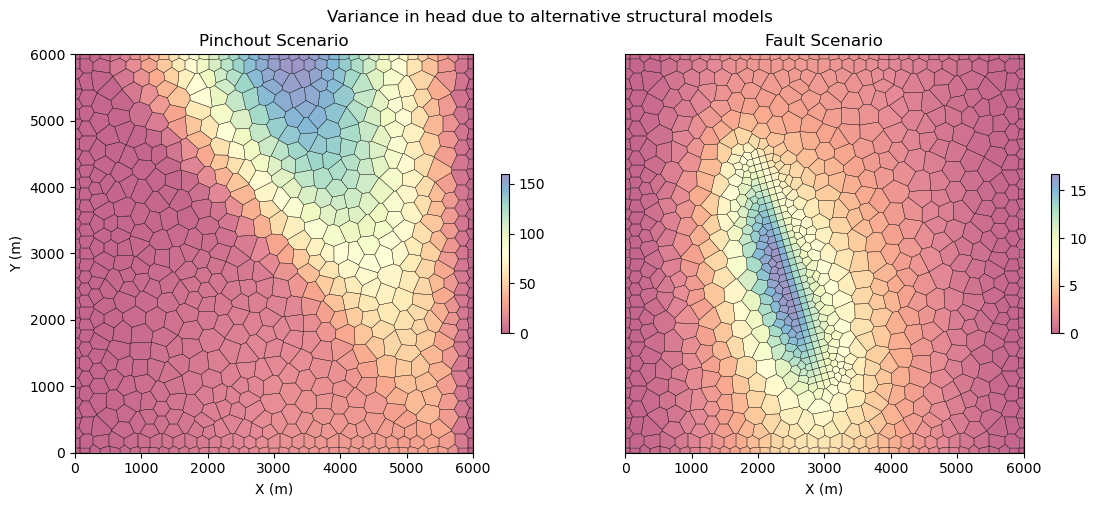

In [21]:
figure7(P, std_PO, std_FD)